In [52]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import pickle
import torch
import torchaudio

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, ADSTFT

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1802);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


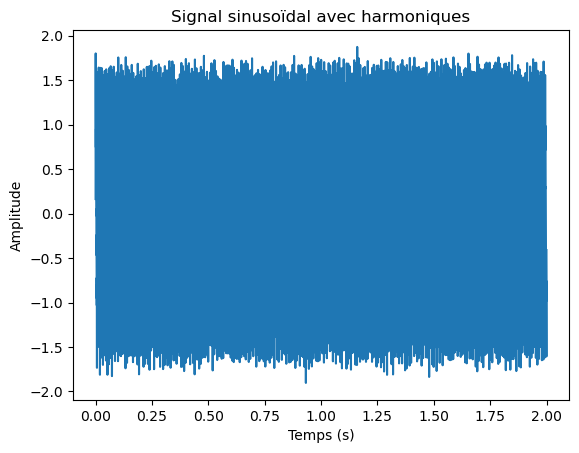

In [53]:
# Définition des paramètres du signal
sr = 8_000
T = 2
t = np.arange(0, T, 1 / sr)
f0 = 150
a = 1
p = 5

x = a * np.sin(2 * np.pi * f0 * t)
for i in range(2, p + 1):
    x += a / i * np.sin(2 * np.pi * i * f0 * t)
x += np.random.normal(0, 0.1, len(t))

# Affichage du signal
plt.plot(t, x)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("Signal sinusoïdal avec harmoniques")

plt.show()

x = torch.tensor(x, dtype=torch.float32, device=device)

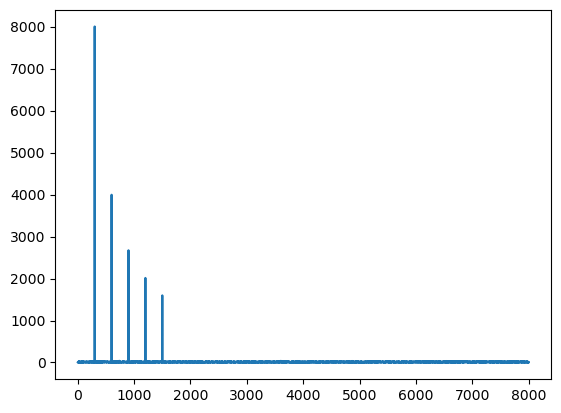

In [54]:
spectrum = torch.fft.rfft(x)
plt.plot(torch.abs(spectrum))

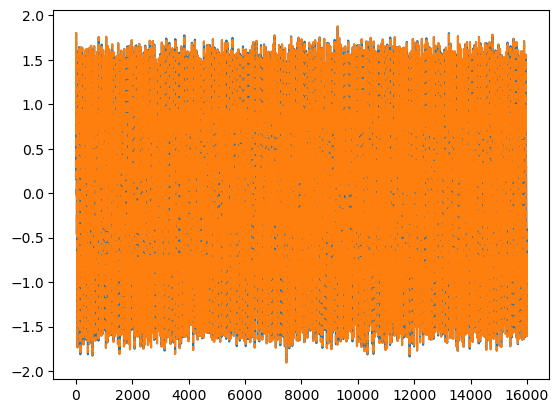

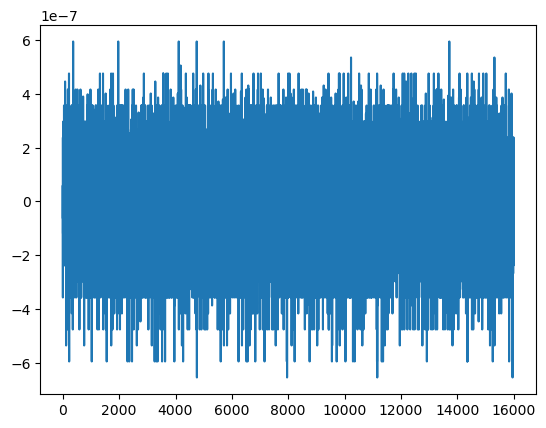

In [55]:
x_hat = torch.fft.irfft(spectrum)
plt.plot(x_hat, label="x_hat")
plt.plot(x, linestyle="--", label="x")

plt.figure()
plt.plot(x - x_hat, label="diff")

In [56]:
n_fft = 1_000
win_length = n_fft
hop_length = 256

torch.Size([501, 63])


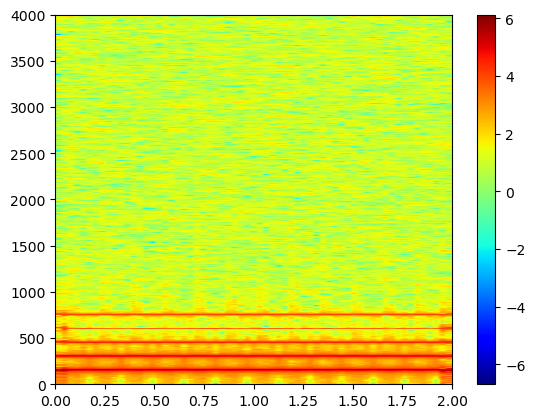

In [57]:
spectrogram = torch.stft(x, n_fft=n_fft, hop_length=hop_length, return_complex=True)
print(spectrogram.shape)
plt.imshow(
    torch.log(torch.abs(spectrogram)).cpu().numpy(),
    aspect="auto",
    origin="lower",
    cmap="jet",
    extent=(0, T, 0, sr / 2),
)
plt.colorbar()

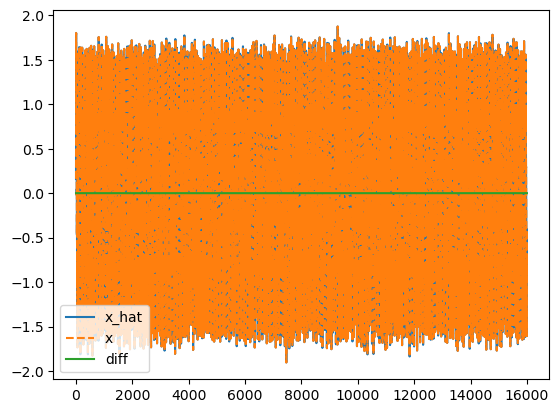

In [58]:
x_hat = torch.istft(spectrogram, hop_length=256, length=len(x), n_fft=1_000)

plt.plot(x_hat, label="x_hat")
plt.plot(x, linestyle="--", label="x")
plt.plot(x - x_hat, label="diff")
plt.legend()

In [59]:
x = torch.unsqueeze(x, 0)

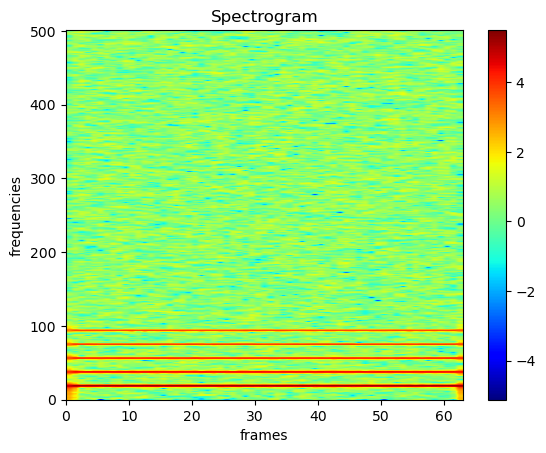

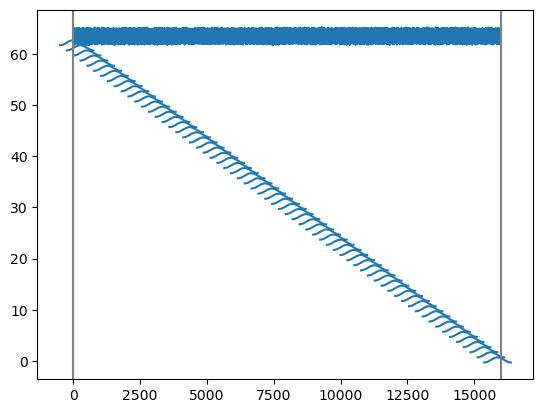

tensor(126275.2656) tensor(29394.3379) tensor(0.2328)


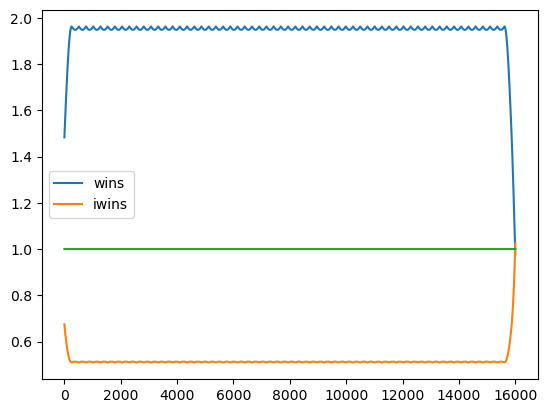

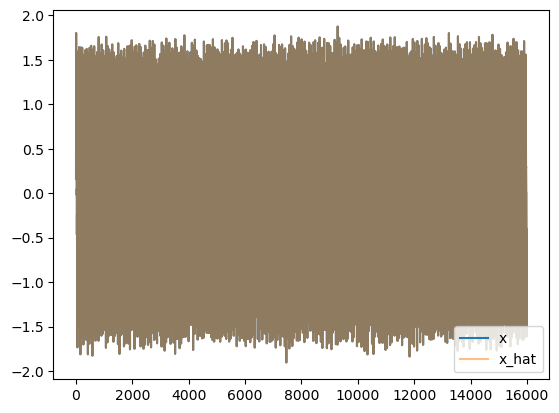

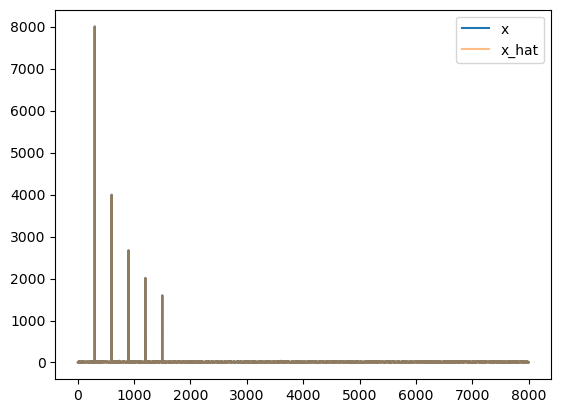

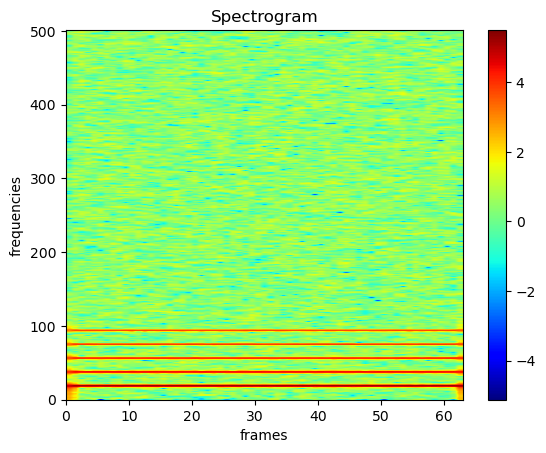

In [60]:
from dstft import DSTFT

dstft = DSTFT(
    x,
    win_length=win_length,
    support=n_fft,
    stride=hop_length,
    win_requires_grad=False,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
spec, stft = dstft(x)

dstft.plot(spec, x, bar=True, weights=False, wins=True)
# plt.figure()
# dstft.plot(stft_ref.abs().unsqueeze(0), x, bar=True, weights=False, wins=True)


print(spec.sum(), stft_ref.abs().sum(), stft_ref.abs().sum() / spec.sum())

x_hat = dstft.inverse_dstft(stft)

# x_hat = x_hat / x_hat.abs().max() * x.abs().max()
plt.figure()
plt.plot(x.squeeze().cpu().detach().numpy(), label="x")
plt.plot(x_hat.squeeze().cpu().detach().numpy(), label="x_hat", alpha=0.5)
plt.legend()

spectrum = torch.fft.rfft(x[0])
spectrum_hat = torch.fft.rfft(x_hat[0])
plt.figure()
plt.plot(torch.abs(spectrum), label="x")
plt.plot(torch.abs(spectrum_hat), alpha=0.5, label="x_hat")
plt.legend()

spec_hat, stft_hat = dstft(x_hat)

dstft.plot(spec_hat, x_hat, bar=True, weights=False, wins=False)

In [61]:
from scipy.io import loadmat

mat = loadmat("../data/fan_flutter.mat")["x"]
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000].squeeze()

In [62]:
n_fft = 1_024
win_length = 1_000
hop_length = 500

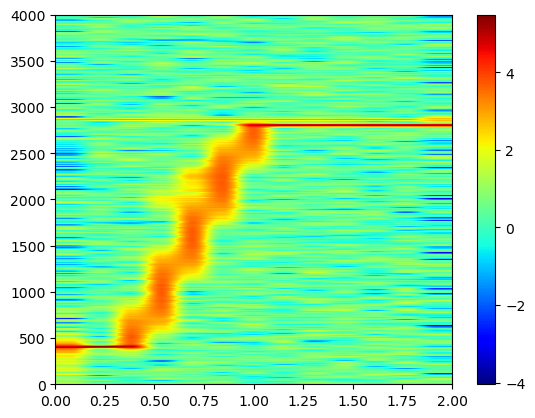

In [63]:
stft_ref = torch.stft(
    x,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    return_complex=True,
    window=torch.hann_window(win_length).to(device),
)

plt.imshow(
    torch.log(torch.abs(stft_ref)).cpu().numpy(),
    aspect="auto",
    origin="lower",
    cmap="jet",
    extent=(0, T, 0, sr / 2),
)
plt.colorbar()

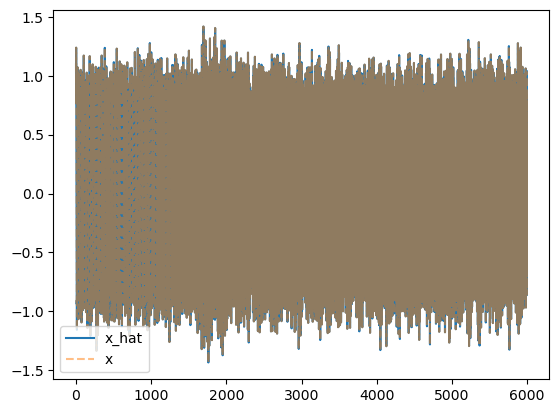

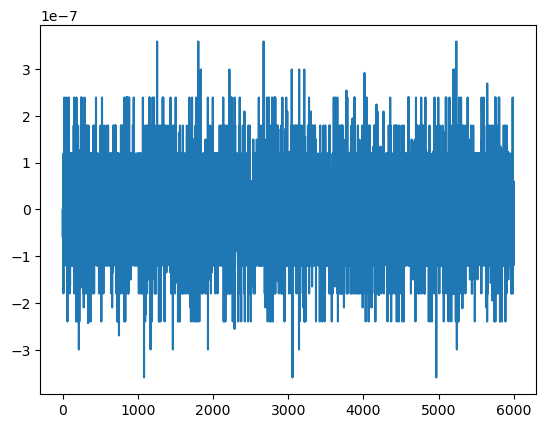

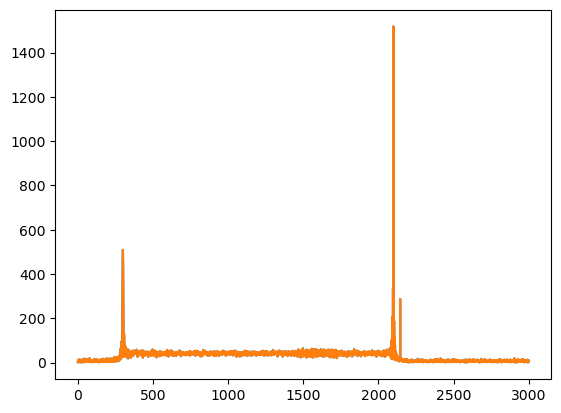

In [64]:
x_hat = torch.zeros_like(x)
torch_istft = torch.istft(
    stft_ref,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    window=torch.hann_window(win_length).to(device),
)
x_hat[: torch_istft.shape[0]] = torch_istft

plt.plot(x_hat, label="x_hat")
plt.plot(x, linestyle="--", label="x", alpha=0.5)
plt.legend()

plt.figure()
plt.plot(x - x_hat, label="diff")

plt.figure()
spectrum = torch.fft.rfft(x)
spectrum_hat = torch.fft.rfft(x_hat)
plt.plot(torch.abs(spectrum))
plt.plot(torch.abs(spectrum_hat))

In [65]:
x = torch.unsqueeze(x, 0)

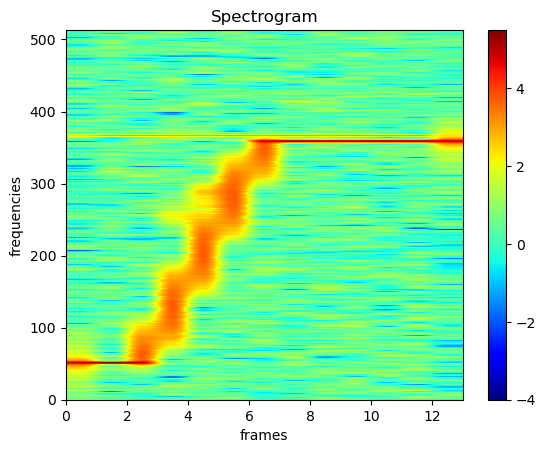

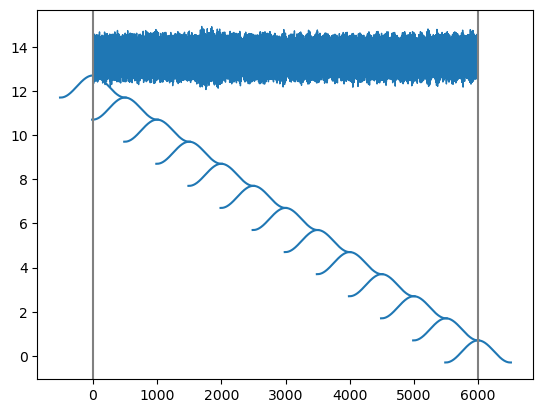

tensor(29244.1191) tensor(29394.3379) tensor(1.0051)


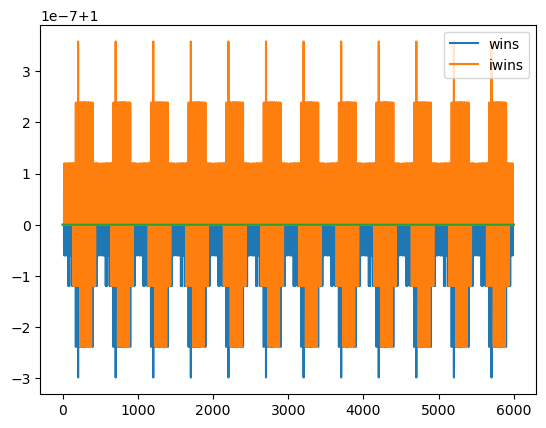

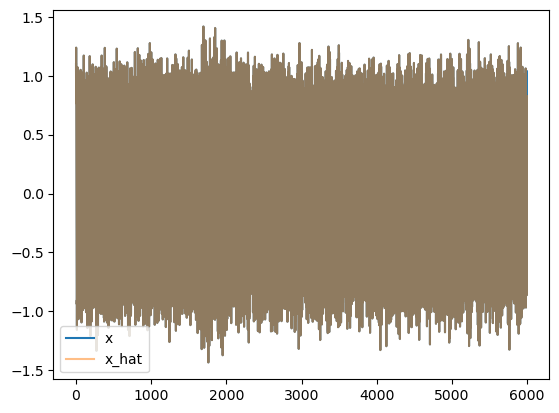

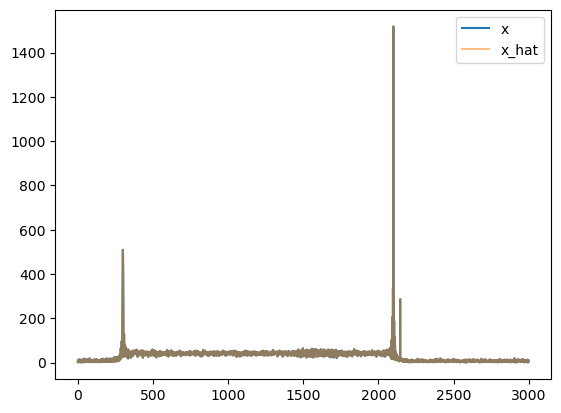

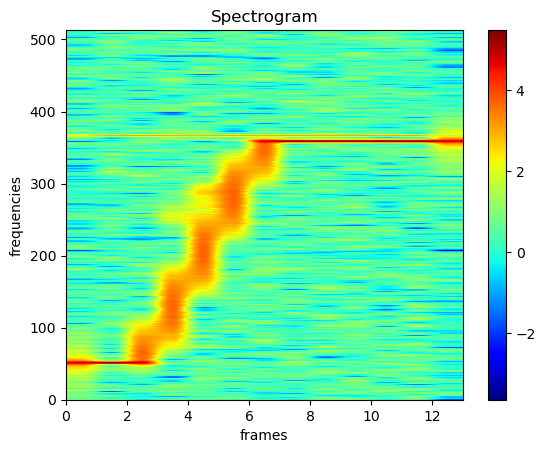

In [66]:
from dstft import DSTFT

dstft = DSTFT(
    x,
    win_length=win_length,
    support=n_fft,
    stride=hop_length,
    win_requires_grad=False,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
spec, stft = dstft(x)

dstft.plot(spec, x, bar=True, weights=False, wins=True)
# plt.figure()
# dstft.plot(stft_ref.abs().unsqueeze(0), x, bar=True, weights=False, wins=True)


print(spec.sum(), stft_ref.abs().sum(), stft_ref.abs().sum() / spec.sum())

x_hat = dstft.inverse_dstft(stft)

# x_hat = x_hat / x_hat.abs().max() * x.abs().max()
plt.figure()
plt.plot(x.squeeze().cpu().detach().numpy(), label="x")
plt.plot(x_hat.squeeze().cpu().detach().numpy(), label="x_hat", alpha=0.5)
plt.legend()

spectrum = torch.fft.rfft(x[0])
spectrum_hat = torch.fft.rfft(x_hat[0])
plt.figure()
plt.plot(torch.abs(spectrum), label="x")
plt.plot(torch.abs(spectrum_hat), alpha=0.5, label="x_hat")
plt.legend()

spec_hat, stft_hat = dstft(x_hat)

dstft.plot(spec_hat, x_hat, bar=True, weights=False, wins=False)

In [67]:
dstft.tap_win.shape

torch.Size([1, 13, 1024])

torch.Size([1, 6000]) torch.Size([1, 6000]) torch.Size([1, 13, 1024])


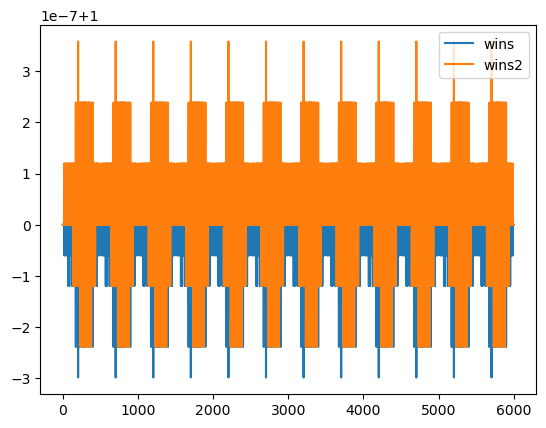

In [68]:
fig, ax = plt.subplots()
wins = torch.zeros_like(x)
wins2 = torch.zeros_like(x)
print(wins.shape, wins2.shape, dstft.tap_win.shape)

for t in range(dstft.T):
    start_idx = max(0, int(dstft.frames[t]))
    end_idx = min(dstft.L, int(dstft.frames[t]) + dstft.N)
    start_dec = start_idx - int(dstft.frames[t])
    end_dec = end_idx - int(dstft.frames[t])
    #print(t, start_idx, end_idx, start_dec, end_dec)
    wins[:, start_idx:end_idx] += (
        dstft.tap_win[:, t, start_dec:end_dec].squeeze().detach().cpu()
    )

wins2[wins > 0] = 1 / wins[wins > 0]
plt.plot(wins[0], label='wins')
plt.plot(wins2[0], label='wins2')
plt.legend()

In [69]:
idx = dstft.frames.floor()[:, None].expand((dstft.T, dstft.N)) + torch.arange(
    0, dstft.N, device=dstft.device
)
iwin = torch.zeros_like(dstft.tap_win)
tt = torch.ones_like(wins)

dstft.tap_win.shape, iwin.shape, idx.shape, wins.shape, wins2.shape, tt.shape

(torch.Size([1, 13, 1024]),
 torch.Size([1, 13, 1024]),
 torch.Size([13, 1024]),
 torch.Size([1, 6000]),
 torch.Size([1, 6000]),
 torch.Size([1, 6000]))

In [70]:
#iwin[dstft.tap_win != 0] = 1 / dstft.tap_win[dstft.tap_win != 0]
#iwin[dstft.tap_win == 0] = 0

In [71]:
iwin = torch.zeros_like(dstft.tap_win)
for t in range(dstft.T):
    start_idx = max(0, int(dstft.frames[t]))
    end_idx = min(dstft.L, int(dstft.frames[t]) + dstft.N)
    start_dec = start_idx - int(dstft.frames[t])
    end_dec = end_idx - int(dstft.frames[t])
    print(t, start_idx, end_idx, start_dec, end_dec)
    iwin[:, t, start_dec:end_dec] = (
        dstft.tap_win[:, t, start_dec:end_dec]
        / wins[:, start_idx:end_idx]
        * wins2[:, start_idx:end_idx]
    )

0 0 512 512 1024
1 0 1012 12 1024
2 488 1512 0 1024
3 988 2012 0 1024
4 1488 2512 0 1024
5 1988 3012 0 1024
6 2488 3512 0 1024
7 2988 4012 0 1024
8 3488 4512 0 1024
9 3988 5012 0 1024
10 4488 5512 0 1024
11 4988 6000 0 1012
12 5488 6000 0 512


In [72]:
print(x_hat.abs().max() / x.abs().max())

tensor(1.)


In [73]:
print(dstft.N / dstft.strides / 4)

tensor([0.5120])


In [74]:
import torch


def istft(spectrogram, hop_length=None, length=None, n_fft=None):
    # Apply inverse real-valued Fast Fourier Transform (irfft)
    waveform = torch.irfft(spectrogram, signal_ndim=1, signal_sizes=(n_fft,))

    # Remove padding if specified
    if length is not None:
        waveform = waveform[..., :length]

    # Apply overlap-and-add to reconstruct the time-domain signal
    if hop_length is not None:
        waveform = torch.nn.functional.unfold(
            waveform.unsqueeze(0), (n_fft, 1), stride=(hop_length, 1)
        ).squeeze(0)
        waveform = waveform[..., :length].sum(dim=1)

    return waveform